<a href="https://colab.research.google.com/github/flohmannjr/PJI410/blob/main/PJI410_proje%C3%A7%C3%B5es_de_notifica%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PJI410 - Projeções (time series) de notificações por local (detalhamento variável)

# Importações

In [54]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os

import tensorflow as tf

from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Add, Bidirectional, Conv1D, Dense, Input, GRU, Lambda, Layer, LSTM, SimpleRNN, Subtract
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from absl import logging as absl_logging

# Configurações

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-v0_8-darkgrid')

SEMENTE = 2001088 + 2001247 + 2003061 + 2005493 + 2008193 + 2008620 + 2008880

CAMINHO_MARCOS = 'marcos'

# Define o nível de log Abseil para 'ERROR'.
# https://abseil.io/docs/python/guides/logging
absl_logging.set_verbosity(absl_logging.ERROR)

## Hiperparâmetros

In [3]:
LOTE_TAMANHO = 32

CAMADAS = 4

CAMADA_UNIDADES      = 64
CAMADA_INICIALIZADOR = 'he_uniform'
CAMADA_ATIVACAO      = 'relu'

PROFUNDO_POTENCIA_INICIAL = 5
PROFUNDO_POTENCIA_FINAL   = 13  # Não incluída
PROFUNDO_REPETICAO        = 2
PROFUNDO_CONSOLIDACAO     = 32

SAIDA_UNIDADES = 1
SAIDA_ATIVACAO = 'linear'

PERDA       = 'mae'
OTIMIZADOR  = Adam
APRENDIZADO = 0.001
METRICAS    = ['mae', 'mse']

ITERACOES = 500

## Funções

In [4]:
!wget https://raw.githubusercontent.com/flohmannjr/PJI410/main/PJI410_funcoes_auxiliares.py

--2023-03-18 20:11:36--  https://raw.githubusercontent.com/flohmannjr/PJI410/main/PJI410_funcoes_auxiliares.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7246 (7.1K) [text/plain]
Saving to: ‘PJI410_funcoes_auxiliares.py’

PJI410_funcoes_auxi 100%[===================>]   7.08K  --.-KB/s    in 0s      

2023-03-18 20:11:37 (46.7 MB/s) - ‘PJI410_funcoes_auxiliares.py’ saved [7246/7246]



In [5]:
from PJI410_funcoes_auxiliares import criar_janelas, criar_marco_modelo, grafico_series, metricas_modelo, separar_janelas_treino_teste, set_global_determinism

# Dados

In [6]:
df_populacao  = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_populacao.csv')
df_municipios = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_municipios.csv')
df_unidades   = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_unidades.csv')

df_notificacoes_por_unidade = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_notificacoes_por_unidade.zip', parse_dates=['Segunda-feira'])
df_notificacoes_por_unidade = df_notificacoes_por_unidade[['UF', 'Municipio', 'Unidade', 'Segunda-feira', 'Quantidade']]
df_notificacoes_por_unidade = df_notificacoes_por_unidade.sort_values(by=['UF', 'Municipio', 'Unidade', 'Segunda-feira']).reset_index(drop=True)

df_notificacoes_por_municipio = df_notificacoes_por_unidade[['UF', 'Municipio', 'Segunda-feira', 'Quantidade']].groupby(by=['UF', 'Municipio', 'Segunda-feira']).sum()
df_notificacoes_por_municipio = df_notificacoes_por_municipio.sort_index().reset_index()

df_notificacoes_por_uf = df_notificacoes_por_unidade[['UF', 'Segunda-feira', 'Quantidade']].groupby(by=['UF', 'Segunda-feira']).sum()
df_notificacoes_por_uf = df_notificacoes_por_uf.sort_index().reset_index()

df_notificacoes_por_semana = df_notificacoes_por_unidade[['Segunda-feira', 'Quantidade']].groupby(by=['Segunda-feira']).sum()
df_notificacoes_por_semana = df_notificacoes_por_semana.sort_index().reset_index()

In [7]:
dados = df_notificacoes_por_semana
q_treino = int(len(dados) * 0.8)

quantidades = dados['Quantidade'].to_numpy().astype('float32')

In [8]:
X_train = dados[:q_treino]['Segunda-feira'].to_numpy()
y_train = dados[:q_treino]['Quantidade'].to_numpy()

X_test = dados[q_treino:]['Segunda-feira'].to_numpy()
y_test = dados[q_treino:]['Quantidade'].to_numpy()

In [9]:
len(quantidades), len(X_train), len(y_train), len(X_test), len(y_test)

(112, 89, 89, 23, 23)

# Modelos

In [10]:
modelos  = [None] * 20
metricas = [None] * 20

## Modelo 0: Ingênuo

Naïve method: https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method

Para previsões ingênuas, simplesmente definimos todas as previsões como o valor da observação anterior.

In [11]:
y_pred = y_test[:-1]

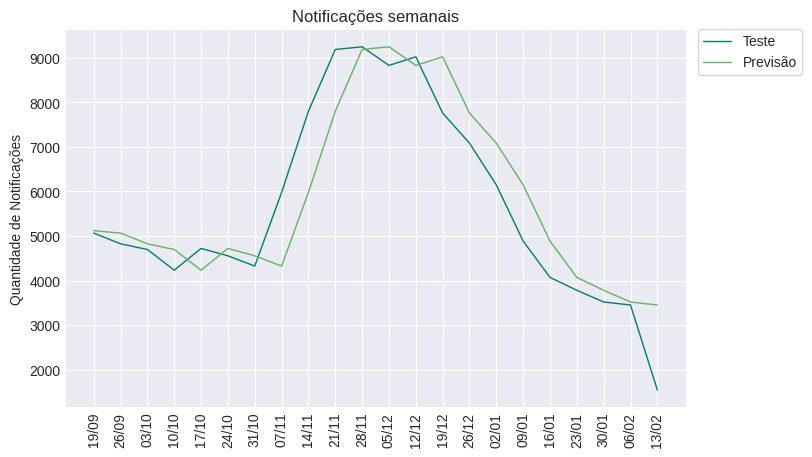

In [12]:
grafico_series(X_teste=X_test[1:], y_teste=y_test[1:],
               X_previsao=X_test[1:], y_previsao=y_pred)

In [13]:
metricas[0] = metricas_modelo(y_test[1:], y_pred)

In [14]:
metricas[0]

{'Mean Absolute Error': 671.7727272727273,
 'Root Mean Squared Error': 898.8617296842207,
 'Mean Absolute Percentage Error': 0.15459536195210424}

## Modelo 1: Denso (7 janelas, 1 horizonte)

In [15]:
janela_tamanho = 7
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(quantidades, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [16]:
%%time

set_global_determinism(seed=SEMENTE)

modelo_nome = f'modelo_1_denso_7j_1h'

modelos[1] = Sequential(name=modelo_nome)

[modelos[1].add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO, name=f'camada_oculta_{c}')) for c in range(CAMADAS)]
modelos[1].add(Dense(units=horizonte_tamanho, activation=SAIDA_ATIVACAO, name='camada_saida'))

modelos[1].compile(loss=PERDA,
                   optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

modelos[1].fit(x=janelas_treino,
               y=horizontes_treino,
               epochs=ITERACOES,
               batch_size=LOTE_TAMANHO,
               validation_data=(janelas_teste, horizontes_teste),
               callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
               verbose=0)

modelos[1] = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))

previsoes = modelos[1].predict(janelas_teste, verbose=0)

metricas[1] = metricas_modelo(horizontes_teste[:, -1], y_previsao=previsoes[:, -1])

print(metricas[1])

{'Mean Absolute Error': 546.68, 'Root Mean Squared Error': 803.5094, 'Mean Absolute Percentage Error': 0.12658593}
CPU times: user 34.2 s, sys: 2.89 s, total: 37.1 s
Wall time: 49.9 s


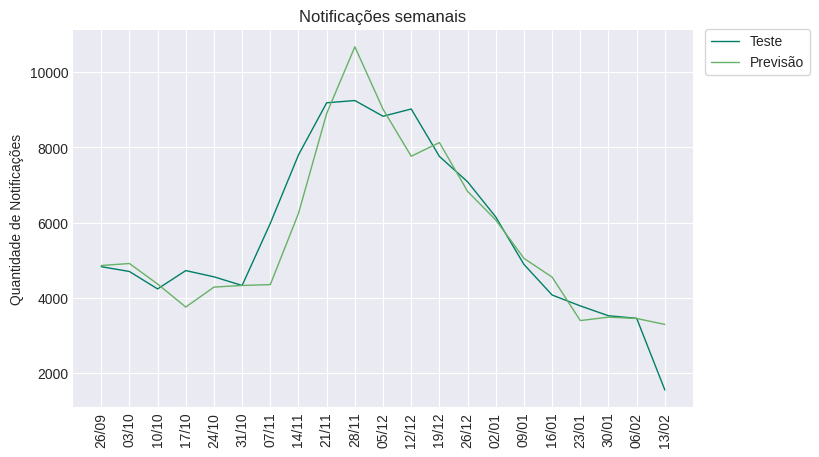

In [17]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, -1],
               X_previsao=X_test[-len(janelas_teste):], y_previsao=previsoes[:, -1])

## Modelo 2: Denso (14 janelas, 1 horizonte)

In [18]:
janela_tamanho = 14
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(quantidades, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [19]:
%%time

set_global_determinism(seed=SEMENTE)

modelo_nome = f'modelo_2_denso_14j_1h'

modelos[2] = Sequential(name=modelo_nome)

[modelos[2].add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO, name=f'camada_oculta_{c}')) for c in range(CAMADAS)]
modelos[2].add(Dense(units=horizonte_tamanho, activation=SAIDA_ATIVACAO, name='camada_saida'))

modelos[2].compile(loss=PERDA,
                   optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

modelos[2].fit(x=janelas_treino,
               y=horizontes_treino,
               epochs=ITERACOES,
               batch_size=LOTE_TAMANHO,
               validation_data=(janelas_teste, horizontes_teste),
               callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
               verbose=0)

modelos[2] = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))

previsoes = modelos[2].predict(janelas_teste, verbose=0)

metricas[2] = metricas_modelo(horizontes_teste[:, -1], y_previsao=previsoes[:, -1])

print(metricas[2])

{'Mean Absolute Error': 713.8544, 'Root Mean Squared Error': 1019.5707, 'Mean Absolute Percentage Error': 0.14560327}
CPU times: user 44.5 s, sys: 1.38 s, total: 45.9 s
Wall time: 1min 23s


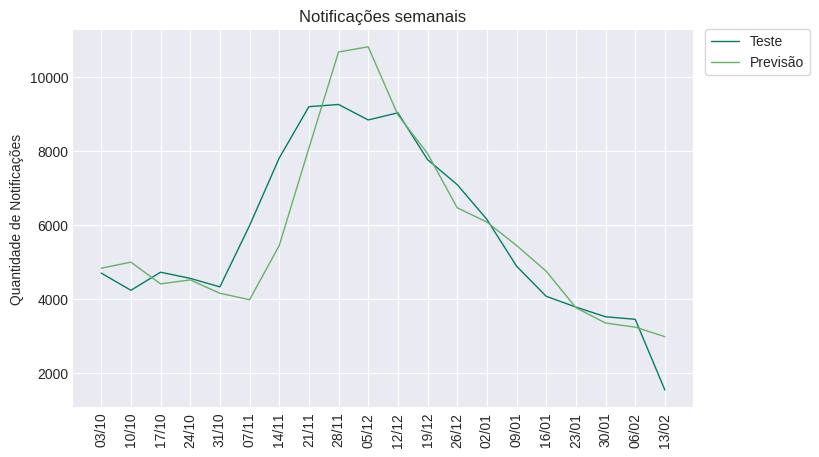

In [20]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, -1],
               X_previsao=X_test[-len(janelas_teste):], y_previsao=previsoes[:, -1])

## Modelo 3: Denso (3 janelas, 1 horizonte)

In [21]:
janela_tamanho = 3
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(quantidades, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [22]:
%%time

set_global_determinism(seed=SEMENTE)

modelo_nome = 'modelo_3_denso_3j_1h'

modelos[3] = Sequential(name=modelo_nome)

[modelos[3].add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO, name=f'camada_oculta_{c}')) for c in range(CAMADAS)]
modelos[3].add(Dense(units=horizonte_tamanho, activation=SAIDA_ATIVACAO, name='camada_saida'))

modelos[3].compile(loss=PERDA,
                   optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

modelos[3].fit(x=janelas_treino,
               y=horizontes_treino,
               epochs=ITERACOES,
               batch_size=LOTE_TAMANHO,
               validation_data=(janelas_teste, horizontes_teste),
               callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
               verbose=0)

modelos[3] = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))

previsoes = modelos[3].predict(janelas_teste, verbose=0)

metricas[3] = metricas_modelo(horizontes_teste[:, -1], y_previsao=previsoes[:, -1])

print(metricas[3])

{'Mean Absolute Error': 521.62115, 'Root Mean Squared Error': 756.00214, 'Mean Absolute Percentage Error': 0.12706278}
CPU times: user 34.7 s, sys: 1.33 s, total: 36 s
Wall time: 39.2 s


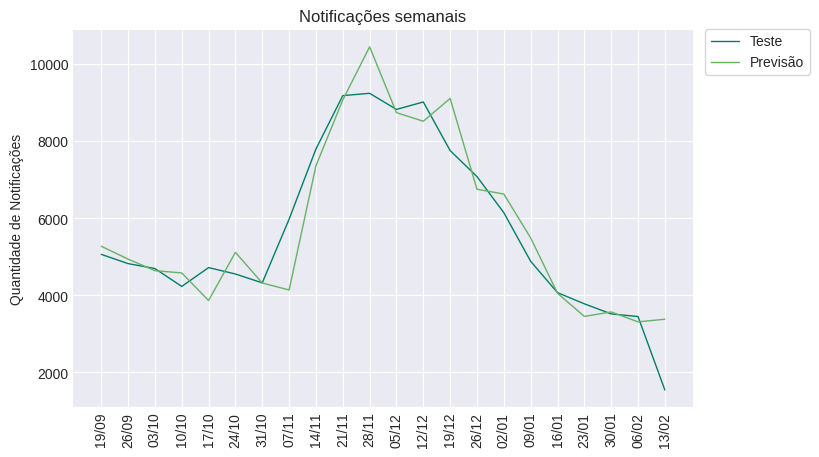

In [23]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, -1],
               X_previsao=X_test[-len(janelas_teste):], y_previsao=previsoes[:, -1])

## Modelo 4: Convulacional

In [24]:
janela_tamanho = 7
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(quantidades, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [25]:
%%time

set_global_determinism(seed=SEMENTE)

modelo_nome = 'modelo_4_convulacional'

modelos[4] = Sequential(name=modelo_nome)

modelos[4].add(Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda'))  # Adiciona uma dimensão aos dados.

modelos[4].add(Conv1D(filters=CAMADA_UNIDADES,
                      kernel_size=janela_tamanho,
                      kernel_initializer=CAMADA_INICIALIZADOR,
                      padding='causal',
                      activation=CAMADA_ATIVACAO,
                      name='camada_convulacional'))

modelos[4].add(Dense(units=horizonte_tamanho, activation=SAIDA_ATIVACAO, name='camada_saida'))

modelos[4].compile(loss=PERDA,
                   optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

modelos[4].fit(x=janelas_treino,
               y=horizontes_treino,
               epochs=ITERACOES,
               batch_size=LOTE_TAMANHO,
               validation_data=(janelas_teste, horizontes_teste),
               callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
               verbose=0)

modelos[4] = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))

previsoes = modelos[4].predict(janelas_teste, verbose=0)

metricas[4] = metricas_modelo(tf.squeeze(horizontes_teste), y_previsao=tf.squeeze(previsoes))

print(metricas[4])

{'Mean Absolute Error': 560.06354, 'Root Mean Squared Error': 790.44147, 'Mean Absolute Percentage Error': 0.1288704}
CPU times: user 1min 15s, sys: 2.3 s, total: 1min 17s
Wall time: 1min 23s


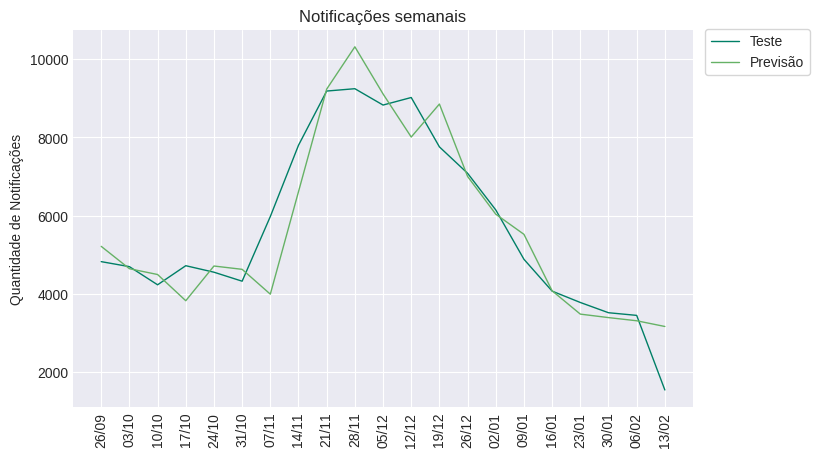

In [26]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes))

## Modelo 5: N-BEATS

N-BEATS: Neural basis expansion analysis for interpretable time series forecasting https://arxiv.org/abs/1905.10437

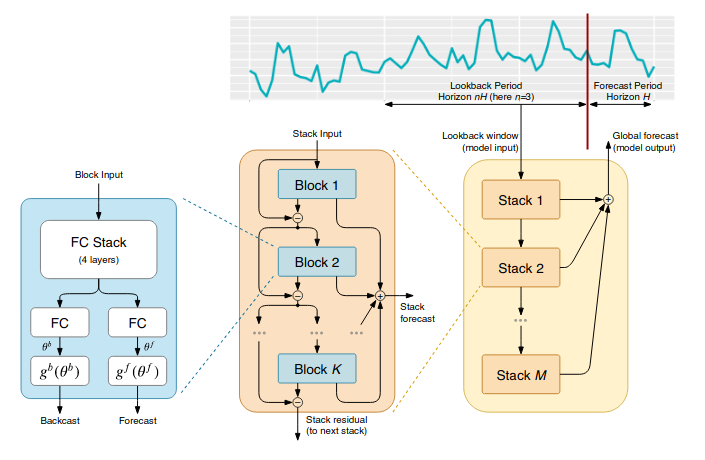

(Do artigo) **Figure 1: Proposed architecture**. The basic building block is a multi-layer Fully Connected (FC) network with ReLU nonlinearities. It predicts basis expansion coefficients both forward, $\theta^f$ (forecast), and backward, $\theta^b$ (backcast). Blocks are organized into stacks using doubly residual stacking principle. A stack may have layers with shared $g^b$ and $g^f$. Forecasts are aggregated in hierarchical fashion. This enables building a very deep neural network with interpretable outputs.


Making new Layers and Models via subclassing https://www.tensorflow.org/guide/keras/custom_layers_and_models

De acordo com o [código fonte](https://github.com/tensorflow/tensorflow/blob/fcc4b966f1265f466e82617020af93670141b009/tensorflow/python/keras/engine/base_layer.py#L308-L316) (em 08.03.2023), os kwargs permitidos pela classe `Layer` são: `input_dim`, `input_shape`, `batch_input_shape`, `batch_size`, `weights`, `activity_regularizer` e `autocast`. Além destes, `Layer` possui os argumentos `trainable`, `name`, `dtype` e `dynamic`.

In [27]:
# A seção 3 do artigo descreve a arquitetura do modelo.
# Para este modelo foi utilizada a arquitetura genérica, descrita na seção 3.3, que não utiliza conhecimentos específicos de séries temporais.

class NBeatsBlock(Layer):

    def __init__(self,
                 input_size: int,
                 horizon: int,
                 n_neurons: int,
                 **kwargs):

        super().__init__(**kwargs)

        self.input_size = input_size  # Tamanho da entrada.
        self.horizon    = horizon     # Tamanho da saída.
        self.n_neurons  = n_neurons   # Quantidade de neurônios.

        self.theta_size = input_size + horizon  # Tamanho do coeficiente de expansão.

        self.hidden      = [Dense(units=n_neurons, activation='relu') for _ in range(4)]  # Camadas densas (FC) ReLU (x4).
        self.theta_layer = Dense(units=self.theta_size, activation='linear')              # Camada theta linear, para backcast e forecast.

    def call(self, inputs):

        x = inputs

        for layer in self.hidden:
            x = layer(x)

        theta = self.theta_layer(x)

        backcast = theta[:, :self.input_size]
        forecast = theta[:, -self.horizon:]

        return backcast, forecast

In [28]:
# Hiperparâmetros (Tabela 18)

NBEATS_ITERACOES = 5000
NBEATS_NEURONIOS = 512
NBEATS_PILHAS    = 30
NBEATS_LOTE      = 1024
NBEATS_ENTRADA   = janela_tamanho * horizonte_tamanho
NBEATS_HORIZONTE = horizonte_tamanho

In [29]:
janela_tamanho = 7
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(quantidades, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

dataset_janelas_treino    = Dataset.from_tensor_slices(janelas_treino)
dataset_janelas_teste     = Dataset.from_tensor_slices(janelas_teste)
dataset_horizontes_treino = Dataset.from_tensor_slices(horizontes_treino)
dataset_horizontes_teste  = Dataset.from_tensor_slices(horizontes_teste)

dataset_treino = Dataset.zip((dataset_janelas_treino, dataset_horizontes_treino))
dataset_teste  = Dataset.zip((dataset_janelas_teste, dataset_horizontes_teste))

dataset_treino = dataset_treino.batch(NBEATS_LOTE).prefetch(AUTOTUNE)
dataset_teste  = dataset_teste.batch(NBEATS_LOTE).prefetch(AUTOTUNE)

In [30]:
%%time

set_global_determinism(seed=SEMENTE)

modelo_nome = 'modelo_5_nbeats'

entradas = Input(shape=(NBEATS_ENTRADA), name='camada_entrada')

residuo, previsao = NBeatsBlock(input_size=NBEATS_ENTRADA,
                                horizon=NBEATS_HORIZONTE,
                                n_neurons=NBEATS_NEURONIOS,
                                name='bloco_0')(entradas)

for p in range(1, NBEATS_PILHAS):

    residuo_pilha, previsao_pilha = NBeatsBlock(input_size=NBEATS_ENTRADA,
                                                horizon=NBEATS_HORIZONTE,
                                                n_neurons=NBEATS_NEURONIOS,
                                                name=f'bloco_{p}')(residuo)

    residuo  = Subtract(name=f"subtracao_{p}")([residuo, residuo_pilha])
    previsao = Add(name=f"adicao_{p}")([previsao, previsao_pilha])

modelos[5] = Model(inputs=entradas, outputs=previsao, name=modelo_nome)

modelos[5].compile(loss=PERDA,
                   optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

modelos[5].fit(dataset_treino,
               epochs=NBEATS_ITERACOES,
               validation_data=dataset_teste,
               callbacks=[EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True),
                          ReduceLROnPlateau(monitor='val_loss', patience=100, verbose=0)],
               verbose=0)

previsoes = modelos[5].predict(dataset_teste, verbose=0)

metricas[5] = metricas_modelo(tf.squeeze(horizontes_teste), y_previsao=tf.squeeze(previsoes))

print(metricas[5])

{'Mean Absolute Error': 553.1122, 'Root Mean Squared Error': 811.468, 'Mean Absolute Percentage Error': 0.12825349}
CPU times: user 1min 11s, sys: 1.44 s, total: 1min 12s
Wall time: 1min 30s


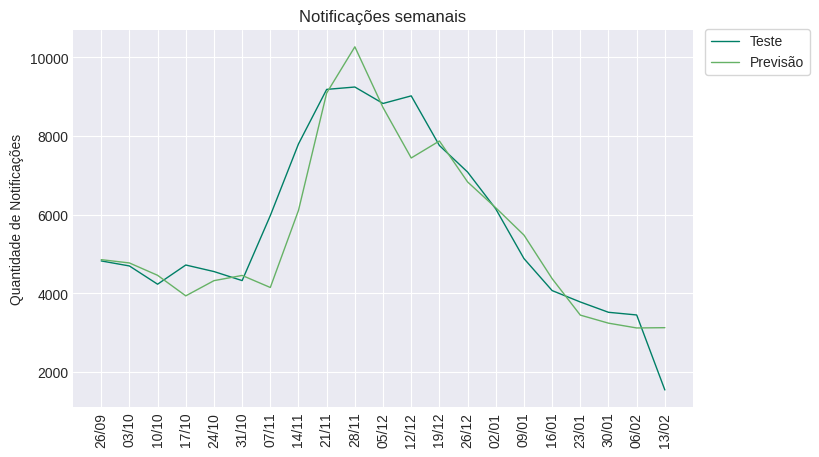

In [31]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes))

## Modelo 6: LSTM

In [32]:
janela_tamanho = 7
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(quantidades, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [33]:
%%time

set_global_determinism(seed=SEMENTE)

modelo_nome = 'modelo_6_lstm'

modelos[6] = Sequential(name=modelo_nome)

modelos[6].add(Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda'))

modelos[6].add(LSTM(units=CAMADA_UNIDADES,
                    kernel_initializer=CAMADA_INICIALIZADOR,
                    activation=CAMADA_ATIVACAO,  # Ativação 'relu' no lugar de 'tanh' por motivo de performance.
                    name='camada_lstm'))

modelos[6].add(Dense(units=CAMADA_UNIDADES, activation=CAMADA_ATIVACAO, name='camada_densa'))

modelos[6].add(Dense(units=horizonte_tamanho, activation=SAIDA_ATIVACAO, name='camada_saida'))

modelos[6].compile(loss=PERDA,
                   optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

modelos[6].fit(x=janelas_treino,
               y=horizontes_treino,
               epochs=ITERACOES,
               batch_size=LOTE_TAMANHO,
               validation_data=(janelas_teste, horizontes_teste),
               callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
               verbose=0)

modelos[6] = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))

previsoes = modelos[6].predict(janelas_teste, verbose=0)

metricas[6] = metricas_modelo(tf.squeeze(horizontes_teste), y_previsao=tf.squeeze(previsoes))

print(metricas[6])

{'Mean Absolute Error': 654.9594, 'Root Mean Squared Error': 833.1828, 'Mean Absolute Percentage Error': 0.15123247}
CPU times: user 1min 42s, sys: 2.57 s, total: 1min 45s
Wall time: 1min 42s


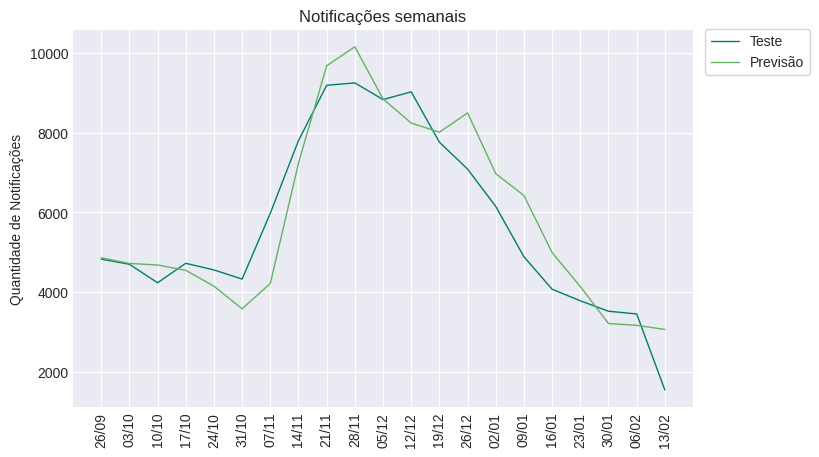

In [34]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes))

## Modelo 7: Denso Profundo  (7 janelas, 1 horizonte)

In [35]:
janela_tamanho = 7
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(quantidades, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [36]:
%%time

set_global_determinism(seed=SEMENTE)

modelo_nome = 'modelo_7_denso_profundo_7j_1h'

modelos[7] = Sequential(name=modelo_nome)

for potencia in range(PROFUNDO_POTENCIA_INICIAL, PROFUNDO_POTENCIA_FINAL):
    unidades = 2 ** potencia
    [modelos[7].add(Dense(units=unidades, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO, name=f'camada_oculta_{unidades}_{r}')) for r in range(PROFUNDO_REPETICAO)]

modelos[7].add(Dense(units=PROFUNDO_CONSOLIDACAO, activation=CAMADA_ATIVACAO, name='camada_consolidacao'))
modelos[7].add(Dense(units=horizonte_tamanho, activation=SAIDA_ATIVACAO, name='camada_saida'))

modelos[7].compile(loss=PERDA,
                   optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

modelos[7].fit(x=janelas_treino,
               y=horizontes_treino,
               epochs=ITERACOES,
               batch_size=LOTE_TAMANHO,
               validation_data=(janelas_teste, horizontes_teste),
               callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
               verbose=0)

modelos[7] = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))

previsoes = modelos[7].predict(janelas_teste, verbose=0)

metricas[7] = metricas_modelo(horizontes_teste[:, -1], y_previsao=previsoes[:, -1])

print(metricas[7])

{'Mean Absolute Error': 468.37527, 'Root Mean Squared Error': 727.79565, 'Mean Absolute Percentage Error': 0.11650222}
CPU times: user 1min 12s, sys: 11.2 s, total: 1min 23s
Wall time: 2min 25s


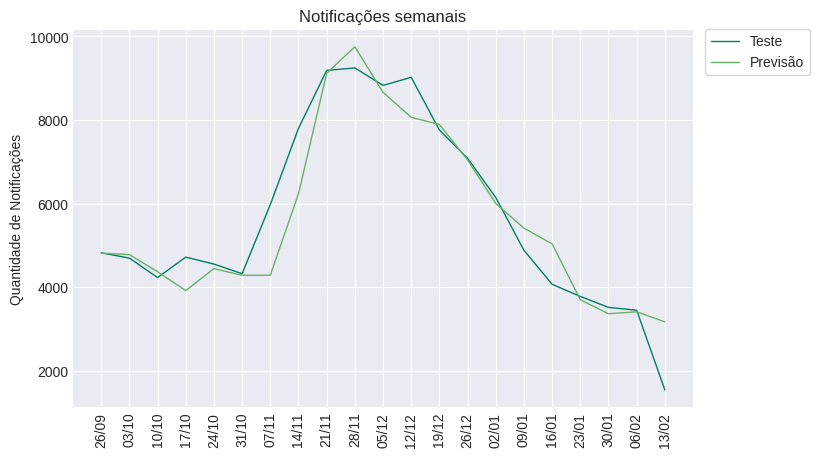

In [37]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, -1],
               X_previsao=X_test[-len(janelas_teste):], y_previsao=previsoes[:, -1])

## Modelo 8: Denso Profundo  (3 janelas, 1 horizonte)

In [38]:
janela_tamanho = 3
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(quantidades, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [39]:
%%time

set_global_determinism(seed=SEMENTE)

modelo_nome = 'modelo_8_denso_profundo_3j_1h'

modelos[8] = Sequential(name=modelo_nome)

for potencia in range(PROFUNDO_POTENCIA_INICIAL, PROFUNDO_POTENCIA_FINAL):
    unidades = 2 ** potencia
    [modelos[8].add(Dense(units=unidades, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO, name=f'camada_oculta_{unidades}_{r}')) for r in range(PROFUNDO_REPETICAO)]

modelos[8].add(Dense(units=PROFUNDO_CONSOLIDACAO, activation=CAMADA_ATIVACAO, name='camada_consolidacao'))
modelos[8].add(Dense(units=horizonte_tamanho, activation=SAIDA_ATIVACAO, name='camada_saida'))

modelos[8].compile(loss=PERDA,
                   optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

modelos[8].fit(x=janelas_treino,
               y=horizontes_treino,
               epochs=ITERACOES,
               batch_size=LOTE_TAMANHO,
               validation_data=(janelas_teste, horizontes_teste),
               callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
               verbose=0)

modelos[8] = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))

previsoes = modelos[8].predict(janelas_teste, verbose=0)

metricas[8] = metricas_modelo(horizontes_teste[:, -1], y_previsao=previsoes[:, -1])

print(metricas[8])

{'Mean Absolute Error': 479.3589, 'Root Mean Squared Error': 703.64453, 'Mean Absolute Percentage Error': 0.11823643}
CPU times: user 1min 17s, sys: 14.3 s, total: 1min 32s
Wall time: 2min 26s


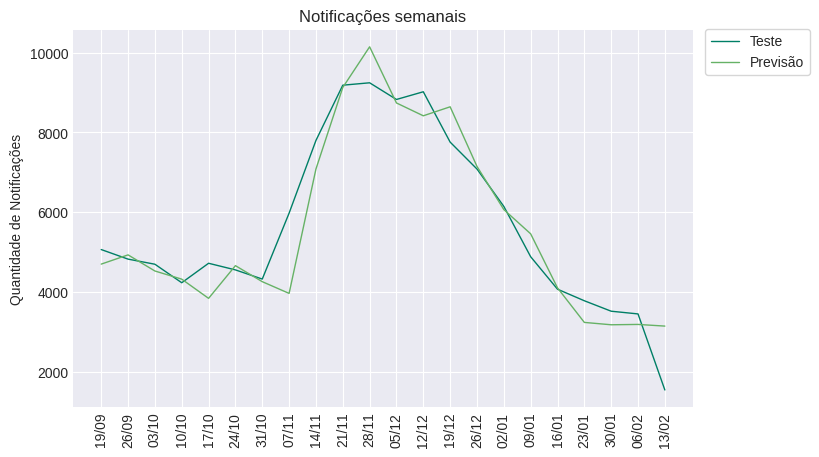

In [40]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, -1],
               X_previsao=X_test[-len(janelas_teste):], y_previsao=previsoes[:, -1])

## Modelo 9: GRU

In [68]:
janela_tamanho = 7
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(quantidades, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [69]:
%%time

set_global_determinism(seed=SEMENTE)

modelo_nome = 'modelo_9_gru'

modelos[9] = Sequential(name=modelo_nome)

modelos[9].add(Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda'))

modelos[9].add(GRU(units=CAMADA_UNIDADES,
                   kernel_initializer=CAMADA_INICIALIZADOR,
                   activation=CAMADA_ATIVACAO,
                   name='camada_gru'))

modelos[9].add(Dense(units=CAMADA_UNIDADES, activation=CAMADA_ATIVACAO, name='camada_densa'))

modelos[9].add(Dense(units=horizonte_tamanho, activation=SAIDA_ATIVACAO, name='camada_saida'))

modelos[9].compile(loss=PERDA,
                   optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

modelos[9].fit(x=janelas_treino,
               y=horizontes_treino,
               epochs=ITERACOES,
               batch_size=LOTE_TAMANHO,
               validation_data=(janelas_teste, horizontes_teste),
               callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
               verbose=0)

modelos[9] = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))

previsoes = modelos[9].predict(janelas_teste, verbose=0)

metricas[9] = metricas_modelo(tf.squeeze(horizontes_teste), y_previsao=tf.squeeze(previsoes))

print(metricas[9])

{'Mean Absolute Error': 549.0385, 'Root Mean Squared Error': 756.7544, 'Mean Absolute Percentage Error': 0.12645572}
CPU times: user 1min 9s, sys: 2.24 s, total: 1min 11s
Wall time: 1min 25s


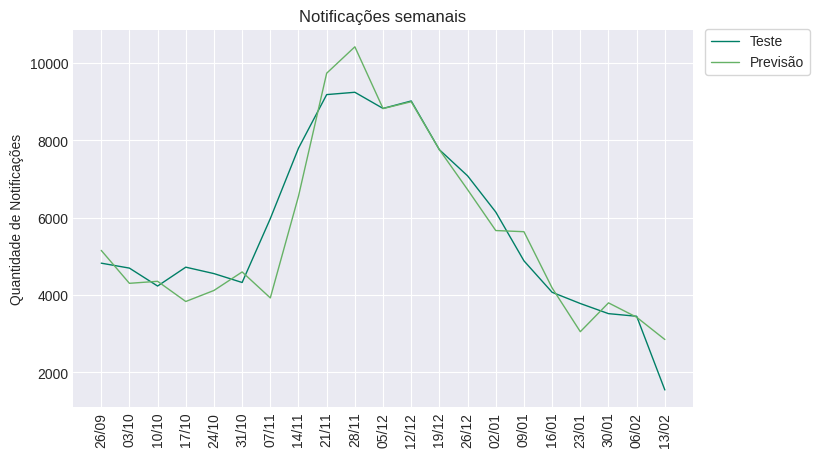

In [70]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes))

## Modelo 10: RNN Simples

In [71]:
janela_tamanho = 7
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(quantidades, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [72]:
%%time

set_global_determinism(seed=SEMENTE)

modelo_nome = 'modelo_10_rnn_simples'

modelos[10] = Sequential(name=modelo_nome)

modelos[10].add(Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda'))

modelos[10].add(SimpleRNN(units=CAMADA_UNIDADES,
                          kernel_initializer=CAMADA_INICIALIZADOR,
                          activation=CAMADA_ATIVACAO,
                          name='camada_rnn_simples'))

modelos[10].add(Dense(units=CAMADA_UNIDADES, activation=CAMADA_ATIVACAO, name='camada_densa'))

modelos[10].add(Dense(units=horizonte_tamanho, activation=SAIDA_ATIVACAO, name='camada_saida'))

modelos[10].compile(loss=PERDA,
                    optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                    metrics=METRICAS)

modelos[10].fit(x=janelas_treino,
                y=horizontes_treino,
                epochs=ITERACOES,
                batch_size=LOTE_TAMANHO,
                validation_data=(janelas_teste, horizontes_teste),
                callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
                verbose=0)

modelos[10] = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))

previsoes = modelos[10].predict(janelas_teste, verbose=0)

metricas[10] = metricas_modelo(tf.squeeze(horizontes_teste), y_previsao=tf.squeeze(previsoes))

print(metricas[10])

{'Mean Absolute Error': 564.0849, 'Root Mean Squared Error': 850.3144, 'Mean Absolute Percentage Error': 0.13219245}
CPU times: user 55 s, sys: 1.52 s, total: 56.6 s
Wall time: 1min 23s


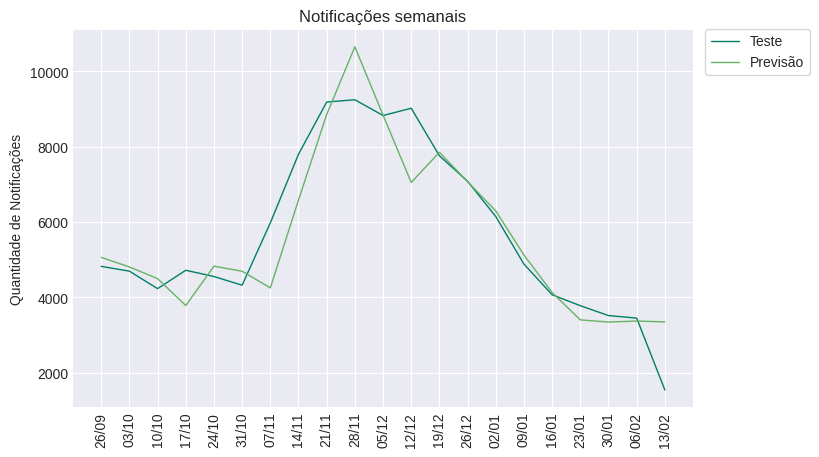

In [73]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes))

## Comparação dos modelos

In [79]:
df_metricas = pd.DataFrame([m for m in metricas if m is not None])

with pd.option_context('display.max_columns', None):
    display(df_metricas.T)

,0,1,2,3,4,5,6,7,8,9,10
Mean Absolute Error,671.772727,546.679993,713.854370,521.621155,560.063538,553.112183,654.959412,468.375275,479.358887,549.038513,564.084900
Root Mean Squared Error,898.861730,803.509399,1019.570679,756.002136,790.441467,811.468018,833.182800,727.795654,703.644531,756.754395,850.314392
Mean Absolute Percentage Error,0.154595,0.126586,0.145603,0.127063,0.128870,0.128253,0.151232,0.116502,0.118236,0.126456,0.132192


In [80]:
df_metricas['Mean Absolute Error'].sort_values()

7     468.375275
8     479.358887
3     521.621155
1     546.679993
9     549.038513
5     553.112183
4     560.063538
10    564.084900
6     654.959412
0     671.772727
2     713.854370
Name: Mean Absolute Error, dtype: float64